In [ ]:
! pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached pystan-3.9.1-py3-none-any.whl (13 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached ephem-4.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl (91 kB)
  Using cached httpstan-4.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (45.3 MB)
  Using cached pysimdjson-6.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  Using cached crashtest-0.3.1-py3-none-any.whl (7.0 kB)
  Using cached pastel-0.2.1-py2.py3-none-any.whl (6.0 kB)
  Using cached pylev-1.4.0-py2.py3-none-any.whl (6.1 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.wh

In [ ]:
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'retina'

In [ ]:
def download_file_from_gdrive(file_url, filename, out_path: Path, overwrite=False):
    """
    Downloads a file from GDrive given an URL
    :param file_url: a string formated as https://drive.google.com/uc?id=<file_id>
    :param: the desired file name
    :param: the desired folder where the file will be downloaded to
    :param overwrite: whether to overwrite the file if it already exists
    """
    file_exists = (out_path / filename).exists()

    if (file_exists and overwrite) or (not file_exists):
        os.system(f'gdown {file_url} -O {out_path}/{filename}')

In [ ]:
df = pd.read_csv("medium_posts.csv", sep='\t')

In [ ]:
df = df[["published", "url"]].dropna().drop_duplicates()

In [ ]:
df["published"] = pd.to_datetime(df["published"])

In [ ]:
df.sort_values(by=["published"]).head(n=3)

,published,url
50931,1970-01-01 00:00:00.001000+00:00,https://medium.com/iiot
40243,1970-01-01 00:00:00.001000+00:00,https://medium.com/@ikaella/melon-rebranding-b...
37395,1970-01-18 05:11:46.500000+00:00,http://www.novosti.rs/%D0%B2%D0%B5%D1%81%D1%82...


In [ ]:
df = df[
    (df["published"] > "2012-08-15") & (df["published"] < "2017-06-26")
].sort_values(by=["published"])
df.head(n=3)

,published,url
24630,2012-08-15 00:25:03.373000+00:00,https://medium.com/launch-day/jean-attempts-to...
24631,2012-08-15 00:25:29.419000+00:00,https://medium.com/launch-day/dan-and-kristin-...
17811,2012-08-15 00:34:59.502000+00:00,https://medium.com/i-m-h-o/the-world-is-social...


In [ ]:
df.tail(n=3)

,published,url
62122,2017-06-25 23:36:01.171000+00:00,https://medium.com/push-the-pace/the-official-...
72471,2017-06-25 23:41:48.295000+00:00,https://medium.com/parti-xyz-developers/%EA%B4...
83283,2017-06-25 23:51:43+00:00,http://www.johanr.com/blog/people-support-dreams


In [ ]:
aggr_df = df.groupby("published")[['url']].count()

In [ ]:
aggr_df.columns = ["posts"]

In [ ]:
aggr_df.head(n=3)

,posts
published,
2012-08-15 00:25:03.373000+00:00,1
2012-08-15 00:25:29.419000+00:00,1
2012-08-15 00:34:59.502000+00:00,1


In [ ]:
daily_df = aggr_df.resample("D").sum()
daily_df.head(n=3)

,posts
published,
2012-08-15 00:00:00+00:00,16
2012-08-16 00:00:00+00:00,11
2012-08-17 00:00:00+00:00,4


In [ ]:
from plotly import graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
from IPython.display import display, IFrame

# Initialize plotly
init_notebook_mode(connected=True)

In [ ]:
def plotly_df(df, title="", width=800, height=500):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode="lines")
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = go.Layout(title=title, width=width, height=height)
    fig = go.Figure(data=data, layout=layout)
    fig.show(renderer='colab')
    return fig

In [ ]:
plotly_df(daily_df, title="Posts on Medium (daily)")

In [ ]:
weekly_df = daily_df.resample("W").sum()

In [ ]:
plotly_df(weekly_df, title="Posts on Medium (weekly)")

In [ ]:
daily_df = daily_df.loc[daily_df.index >= "2015-01-01"]
daily_df.head(n=3)

,posts
published,
2015-01-01 00:00:00+00:00,8
2015-01-02 00:00:00+00:00,11
2015-01-03 00:00:00+00:00,11


In [ ]:
import logging
from prophet import Prophet

logging.getLogger().setLevel(logging.ERROR)

In [ ]:
df = daily_df.reset_index()
df.columns = ["ds", "y"]
df["ds"] = df["ds"].dt.tz_convert(None)
df.tail(n=3)

,ds,y
904,2017-06-23,421
905,2017-06-24,277
906,2017-06-25,253


In [ ]:
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y
874,2017-05-24,375
875,2017-05-25,298
876,2017-05-26,269


In [ ]:
m = Prophet()
m.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_omq_jk/izu5ryxj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_omq_jk/2i2wlfm9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73302', 'data', 'file=/tmp/tmpz_omq_jk/izu5ryxj.json', 'init=/tmp/tmpz_omq_jk/2i2wlfm9.json', 'output', 'file=/tmp/tmpz_omq_jk/prophet_model7arl7e1j/prophet_model-20240624135126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
904,2017-06-23
905,2017-06-24
906,2017-06-25


In [ ]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
904,2017-06-23,277.550165,254.180613,305.428557,277.109323,277.942444,2.297033,2.297033,2.297033,3.474387,3.474387,3.474387,-1.177354,-1.177354,-1.177354,0.0,0.0,0.0,279.847198
905,2017-06-24,278.264671,217.289033,269.300911,277.784512,278.679703,-35.011656,-35.011656,-35.011656,-34.024377,-34.024377,-34.024377,-0.987279,-0.987279,-0.987279,0.0,0.0,0.0,243.253015
906,2017-06-25,278.979178,221.594720,270.670395,278.471944,279.415716,-31.378341,-31.378341,-31.378341,-30.580650,-30.580650,-30.580650,-0.797691,-0.797691,-0.797691,0.0,0.0,0.0,247.600837


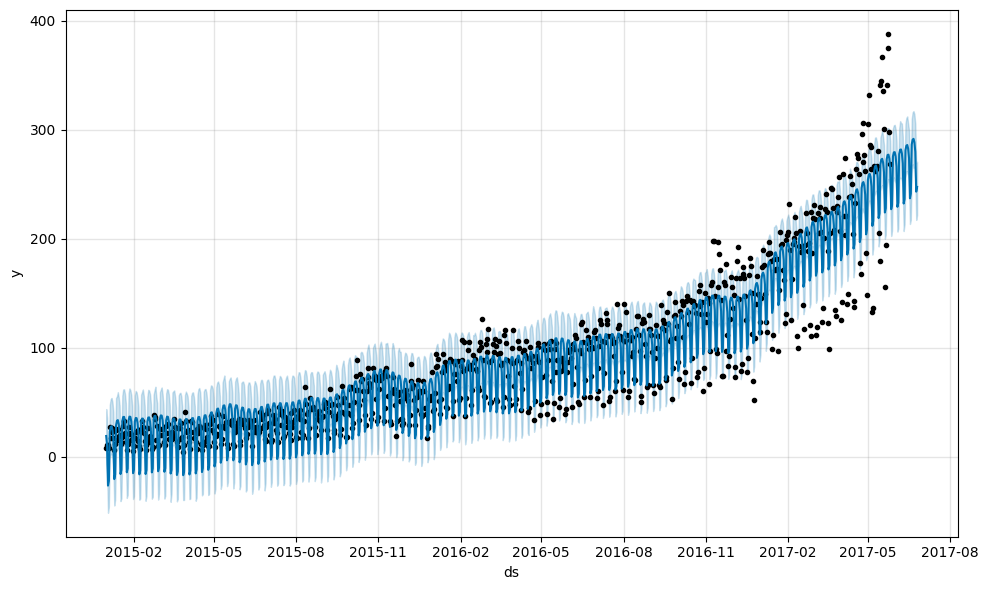

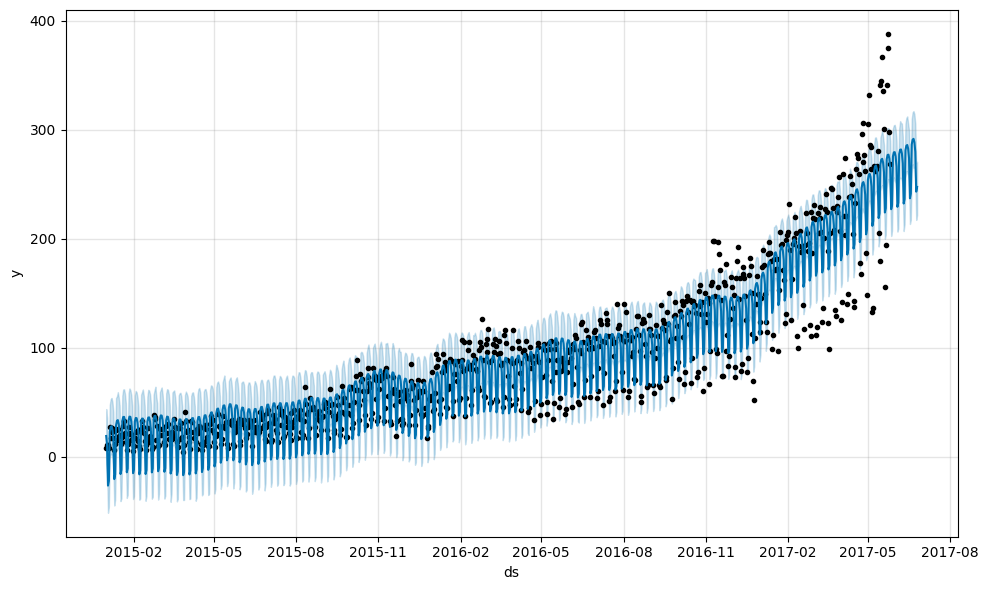

In [ ]:
m.plot(forecast)

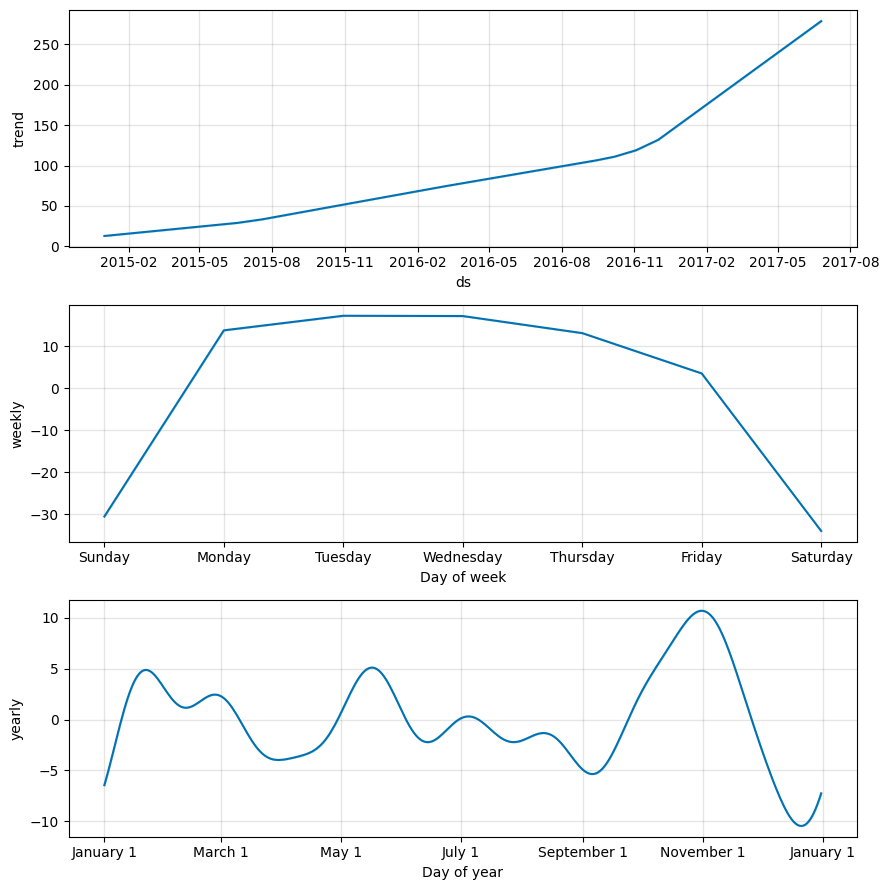

In [ ]:
m.plot_components(forecast);

In [ ]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.

       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]].join(
        historical.set_index("ds")
    )

In [ ]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(n=3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2017-06-23,279.847198,254.180613,305.428557,421
2017-06-24,243.253015,217.289033,269.300911,277
2017-06-25,247.600837,221.594720,270.670395,253


In [ ]:
def calculate_forecast_errors(df, prediction_size):
  df = df.copy()
  df['e'] = df['y'] - df['yhat']
  df['p'] = 100 * df['e'] / df['y']
  predicted_part = df[-prediction_size:]
  error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
  return {'MAPE':error_mean('p'), 'MAE':error_mean('e')}

In [ ]:
for err_name, err_val in calculate_forecast_errors(cmp_df, prediction_size).items():
  print(err_name, err_val)

MAPE 22.602477878539073
MAE 69.81707093439603


In [ ]:
def show_forecast(cmp_df, num_predictions, num_values, title, width=800, height=500):
    """Visualize the forecast."""

    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode="lines")
        args.update(kwargs)
        return go.Scatter(**args)

    lower_bound = create_go(
        "Lower Bound",
        "yhat_lower",
        num_predictions,
        line=dict(width=0),
        marker=dict(color="gray"),
    )
    upper_bound = create_go(
        "Upper Bound",
        "yhat_upper",
        num_predictions,
        line=dict(width=0),
        marker=dict(color="gray"),
        fillcolor="rgba(68, 68, 68, 0.3)",
        fill="tonexty",
    )
    forecast = create_go(
        "Forecast", "yhat", num_predictions, line=dict(color="rgb(31, 119, 180)")
    )
    actual = create_go("Actual", "y", num_values, marker=dict(color="red"))
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title="Posts"), title=title, showlegend=False)
    fig = go.Figure(data=data, layout=layout)
    fig.show(renderer='colab')


show_forecast(cmp_df, prediction_size, 100, "New posts on Medium")

In [ ]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [ ]:
train_df2 = train_df.copy().set_index("ds")

In [ ]:
train_df2.head()

,y
ds,
2015-01-01,8
2015-01-02,11
2015-01-03,11
2015-01-04,8
2015-01-05,27


In [ ]:
train_df2["y"], lambda_prophet = stats.boxcox(train_df2["y"])
train_df2.reset_index(inplace=True)

In [ ]:
train_df2.head()

,ds,y
0,2015-01-01,2.563884
1,2015-01-02,3.056559
2,2015-01-03,3.056559
3,2015-01-04,2.563884
4,2015-01-05,4.622278


In [ ]:
m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=prediction_size)
forecast2 = m2.predict(future2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_omq_jk/f3dfvyl6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_omq_jk/ntpdt5_6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25961', 'data', 'file=/tmp/tmpz_omq_jk/f3dfvyl6.json', 'init=/tmp/tmpz_omq_jk/ntpdt5_6.json', 'output', 'file=/tmp/tmpz_omq_jk/prophet_modelga40x00v/prophet_model-20240624135152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
  forecast2[column] = inverse_boxcox(forecast2[column], lambda_prophet)

In [ ]:
cmp_df2 = make_comparison_dataframe(df, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
    print(err_name, err_value)

MAPE 11.588056198662485
MAE 39.058432040889514


In [ ]:
show_forecast(cmp_df, prediction_size, 100, "No transformations")

In [ ]:
show_forecast(cmp_df2, prediction_size, 100, "Box-Cox transformation")